# Sequence Processing

## Practical 1

_**Analyze a simple time-series dataset and perform univariate time-series forecasting first with a linear model and then with a simple Recurrent Neural Network (RNN) and compare model performance. Also experiment with deep RNNs to check if the model performance improves further.**_

The following experiment considers Chicago Transit Authority (CTA) daily ridership dataset available at   (CTA). This dataset shows system-wide boardings for both bus and rail services provided by CTA and it is available at https://data.cityofchicago.org/. The dataset having updates till August 1, 2024 was considered in this experiment.

In [5]:
# Imports required packages

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
ridership = pd.read_csv("./../Data/CTA-Ridership-Daily_Boarding_Totals_20240829.csv", parse_dates=["service_date"])

In [7]:
display(ridership)

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343
...,...,...,...,...,...
8578,2024-04-26,W,554146,355278,909424
8579,2024-04-27,A,419731,286199,705930
8580,2024-04-28,U,293589,196481,490070
8581,2024-04-29,W,556233,349857,906090


Note that attribute value **W**, **A** ans **U** in attribute **day_type** represent **Weekday**, **Saturday** and **Sunday/Holiday**, respectively.

In [9]:
# Setting date column as index
ridership = ridership.sort_values("service_date").set_index("service_date")

In [10]:
# Checks for the modification into the dataset
display(ridership)

,day_type,bus,rail_boardings,total_rides
service_date,,,,
2001-01-01,U,297192,126455,423647
2001-01-02,W,780827,501952,1282779
2001-01-03,W,824923,536432,1361355
2001-01-04,W,870021,550011,1420032
2001-01-05,W,890426,557917,1448343
...,...,...,...,...
2024-04-26,W,554146,355278,909424
2024-04-27,A,419731,286199,705930
2024-04-28,U,293589,196481,490070


In [11]:
# Drops the calculated column "total_rides" as this is just element-wise addition from columns "bus" and "rail_boardings".
ridership = ridership.drop("total_rides", axis=1)

In [12]:
# remove duplicate observations, if any
ridership = ridership.drop_duplicates()

In [13]:
ridership.shape

(8521, 3)

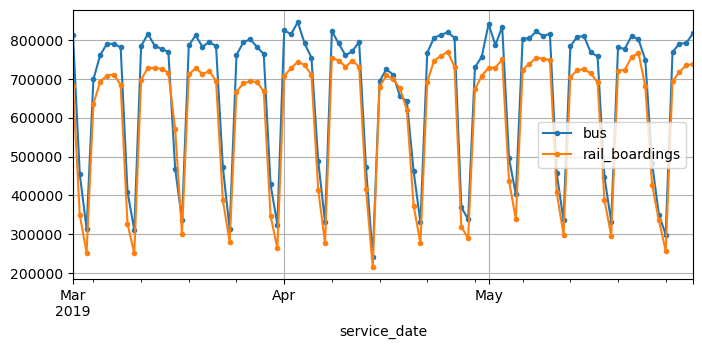

In [14]:
# Looks at the first few months of 2019

ridership["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))

plt.show()

Looking at the above figure, weekly seasonality was observed.

### Naive Forecasting
Creating a baseline model for naive forecasting considering observed weekly seasonality i.e. similar pattern is repeated clearly every week.

To visualize these naive forecasts, the two time-series (for bus and rail boarding) are overlayed and at the same time, both these time-series lagged by one week (i.e., shifted toward the right) are also overlayed using dotted lines.

The second plot in the same figure shows difference (i.e., the value at time _t_ minus the value at time _t_ – 7) between the original and its lagged version for both the time-series.

In [18]:
# Creates a 7-day differencing time-series out of difference between two time-series - the original one
# and other one lagged by one week
diff_7 = ridership[["bus", "rail_boardings"]].diff(7)["2019-03":"2019-05"]

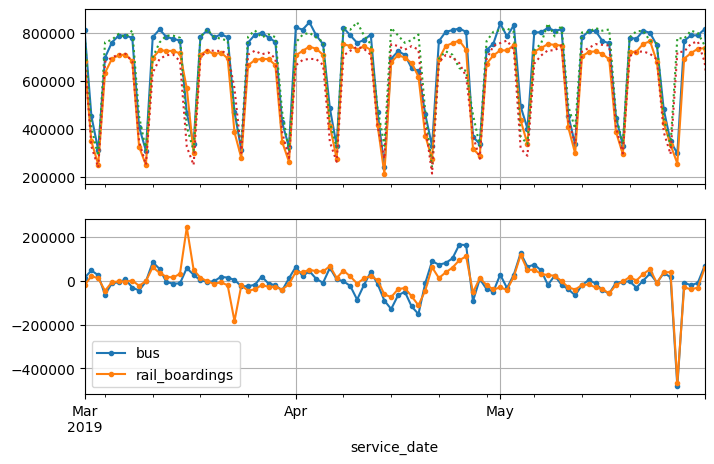

In [19]:
# First shows the two overlayed time-series

# Prepares a figure with two plots - one for the overlayed time-series and 
# other is for the differencing time-series
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

# Plots the original time-series in the first axis
ridership.plot(ax=axs[0], legend=False, marker=".")  

# Plots the lagged time-series in the first axis as overlayed
ridership.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")

# Plots the differencing time-series prepared earlier in the next axis
diff_7.plot(ax=axs[1], grid=True, marker=".")

# [OPTIONAL] Sets y-axis limit of the first plot to zoom into range of interest
axs[0].set_ylim([170_000, 900_000])

# Shows the prepared plot
plt.show()

In [20]:
# Measures the performance of naive forecasting over metric Mean absolute error (MAE), also called mean absolute deviation (MAD)
diff_7.abs().mean()

bus               43915.608696
rail_boardings    42143.271739
dtype: float64

In [21]:
# The same performance is also expressed in Mean Absolute Percentage Error (MAPE)
(diff_7 / ridership[["bus", "rail_boardings"]]["2019-03":"2019-05"]).abs().mean()

bus               0.082938
rail_boardings    0.089948
dtype: float64

The naive forecasts give a MAPE of roughly **8.3%** for bus and **9.0%** for rail boardings.

### Univariate Forecasting
Forecasting tomorrow's rail ridership based (only) on rail ridership [single variable as input] of the past 8 weeks (56 days). 

The inputs to our model will be sequences, each containing 56 values from time steps _t_ – 55 to t. For each input sequence, the model will output a single value as a forecast for time step _t_ + 1.

**Prepares Datasets for Modeling**

In [27]:
# Splits the time-series into three periods, for training, validation and testing
# The values are scaled down by a factor of one million, to ensure the values are near the 0–1 range

rail_train = ridership["rail_boardings"]["2016-01":"2018-12"] / 1e6  # 3 years
rail_val = ridership["rail_boardings"]["2019-01":"2019-05"] / 1e6    # 5 months
rail_test = ridership["rail_boardings"]["2019-06":] / 1e6            # remaining period from 2019-06

In [42]:
# Prepares TensorFlow specific datasets

seq_length = 56    # represents sequence of past 8 weeks (56 days) of ridership data

tf.random.set_seed(42)

rail_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,  # shuffling in training windows is recommended for gradient descent optimizer
    seed=42
)

rail_val_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_val.to_numpy(),
    targets=rail_val[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=False  # shuffling is not required for any testing data including validation data
)

2024-09-10 04:57:17.951980: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Forecasting using A Linear Model

In [50]:
tf.random.set_seed(42)

# Creates a linear model over a dense layer
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[seq_length])])

# Sets callback to stop training when model does improve after a certain number of training iterations
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

# Sets the model optimizer and compiles it with specific loss function and metric
model.compile(
    loss=tf.keras.losses.Huber(),   # Huber loss works well in minimizing MAE
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9), 
    metrics=["mae"])

# Starts model training process over specified training, validation data and callbacks
history = model.fit(rail_train_ds, 
                    validation_data=rail_val_ds, 
                    epochs=500,
                    callbacks=[early_stopping_callback])

Epoch 1/500


2024-09-10 05:11:17.477405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [1040]
	 [[{{node Placeholder/_28}}]]
2024-09-10 05:11:17.477864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [1040]
	 [[{{node Placeholder/_28}}]]


33/33 [==============================] - 1s 7ms/step - loss: 0.1552 - mae: 0.4244 - val_loss: 0.0128 - val_mae: 0.1304
Epoch 2/500
 1/33 [..............................] - ETA: 1s - loss: 0.0185 - mae: 0.1442

2024-09-10 05:11:18.016010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-09-10 05:11:18.016657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


33/33 [==============================] - 0s 2ms/step - loss: 0.0171 - mae: 0.1453 - val_loss: 0.0147 - val_mae: 0.1405
Epoch 3/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0113 - mae: 0.1109 - val_loss: 0.0073 - val_mae: 0.0895
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0081 - mae: 0.0916 - val_loss: 0.0066 - val_mae: 0.0841
Epoch 5/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - mae: 0.0840 - val_loss: 0.0060 - val_mae: 0.0795
Epoch 6/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0065 - mae: 0.0810 - val_loss: 0.0055 - val_mae: 0.0756
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0057 - mae: 0.0763 - val_loss: 0.0052 - val_mae: 0.0730
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0058 - mae: 0.0773 - val_loss: 0.0051 - val_mae: 0.0727
Epoch 9/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0049 - mae: 0.0696 -

In [55]:
# After training, model gets evaluated against validation data

val_loss, val_mae = model.evaluate(rail_val_ds)
print("Validation MAE of the Linear Model:", val_mae * 1e6)

3/3 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0371
37060.31292676926


#### Forecasting Using a Simple RNN

In [62]:
# Resets all the keras states
tf.keras.backend.clear_session()

tf.random.set_seed(42)

# Creates an RNN with 32 recurrent neurons followed by a dense output layer with one output neuron
univar_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [64]:
# Sets callback to stop training when model does improve after a certain number of training iterations
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

# Sets the model optimizer and compiles it with specific loss function and metric
univar_simple_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=["mae"])

# Starts model training process over specified training, validation data and callbacks
history = univar_simple_rnn.fit(
    rail_train_ds, validation_data=rail_val_ds, epochs=500, callbacks=[early_stopping_callback])

Epoch 1/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0511 - mae: 0.2252 - val_loss: 0.0158 - val_mae: 0.1711
Epoch 2/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0184 - mae: 0.1575 - val_loss: 0.0139 - val_mae: 0.1254
Epoch 3/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0105 - mae: 0.1178 - val_loss: 0.0048 - val_mae: 0.0737
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0069 - mae: 0.0902 - val_loss: 0.0031 - val_mae: 0.0609
Epoch 5/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0046 - mae: 0.0706 - val_loss: 0.0041 - val_mae: 0.0677
Epoch 6/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0039 - mae: 0.0626 - val_loss: 0.0024 - val_mae: 0.0433
Epoch 7/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0035 - mae: 0.0579 - val_loss: 0.0025 - val_mae: 0.0450
Epoch 8/500
33/33 [==============================] - 1s 23ms/step - loss: 0.

In [69]:
# After training, model gets evaluated against validation data

val_loss, val_mae = univar_simple_rnn.evaluate(rail_val_ds)
print("Validation MAE of the Simple RNN:", val_mae * 1e6)

3/3 [==============================] - 0s 10ms/step - loss: 0.0018 - mae: 0.0299
Validation MAE of the Simple RNN: 29935.46985089779


The model performance shown above indicates that the Simple RNN worked [MAE: 29935] better than the baseline model [MAE: 42143] and the linear model [MAE: 37060].

#### Forecasting Using a Deep RNN

Now, checks if deep RNN (multiple layers of Simple RNN) works better than simple RNN.

In [73]:
# Resets all the keras states
tf.keras.backend.clear_session()

tf.random.set_seed(42)

# Creates a Deep RNN with multiple layers of simple RNN each with 32 recurrent neurons 
# followed by a dense output layer with one output neuron
univar_deep_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),  # sequence-to-sequence layer
    tf.keras.layers.SimpleRNN(32, return_sequences=True),                         # sequence-to-sequence layer
    tf.keras.layers.SimpleRNN(32),                                                # sequence-to-vector layer
    tf.keras.layers.Dense(1)
])

In [75]:
# Sets callback to stop training when model does improve after a certain number of training iterations
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

# Sets the model optimizer and compiles it specific loss function and metric
univar_deep_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=["mae"])

# Starts model training process over specified training, validation data and callbacks
history = univar_deep_rnn.fit(
    rail_train_ds, validation_data=rail_val_ds, epochs=500, callbacks=[early_stopping_callback])

Epoch 1/500
33/33 [==============================] - 4s 79ms/step - loss: 0.0140 - mae: 0.1250 - val_loss: 0.0052 - val_mae: 0.0796
Epoch 2/500
33/33 [==============================] - 2s 63ms/step - loss: 0.0058 - mae: 0.0744 - val_loss: 0.0045 - val_mae: 0.0742
Epoch 3/500
33/33 [==============================] - 2s 62ms/step - loss: 0.0051 - mae: 0.0692 - val_loss: 0.0033 - val_mae: 0.0591
Epoch 4/500
33/33 [==============================] - 2s 65ms/step - loss: 0.0047 - mae: 0.0648 - val_loss: 0.0021 - val_mae: 0.0408
Epoch 5/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0044 - mae: 0.0635 - val_loss: 0.0020 - val_mae: 0.0372
Epoch 6/500
33/33 [==============================] - 2s 46ms/step - loss: 0.0043 - mae: 0.0628 - val_loss: 0.0021 - val_mae: 0.0407
Epoch 7/500
33/33 [==============================] - 2s 73ms/step - loss: 0.0039 - mae: 0.0573 - val_loss: 0.0023 - val_mae: 0.0421
Epoch 8/500
33/33 [==============================] - 2s 49ms/step - loss: 0.

In [78]:
# After training, model gets evaluated against validation data

val_loss, val_mae = univar_deep_rnn.evaluate(rail_val_ds)
print("Validation MAE of the Deep RNN:", val_mae * 1e6)

3/3 [==============================] - 0s 24ms/step - loss: 0.0018 - mae: 0.0305
Validation MAE of the Deep RNN: 30504.075810313225


The above performance shows that deep RNN is better than baseline model [MAE: 42143] and the linear model [MAE: 37060], but it couldn't beat simple RNN [MAE: 29935]. Hence, deep RNN might not be a good fit for this case. Now, let's experiment with multivariate forecasting to check if it can improve model performance.

## Practical 2

_**Consider the same dataset and perform multivariate time-series forecasting and compare model performance with the one from the previous experiment.**_

### Multivariate Forecasting

Forecasting tomorrow's rail ridership based on both bus and rail ridership [multiple variables as input] of the past 8 weeks (56 days). Day type (weekday, a weekend, or a holiday) is also take into consideration.

**Prepares Datasets for Modeling**

In [125]:
# Prepares dataset with multiple features as input for modeling
# Ridership values are once again scaled down by a factor of one million, 
# to ensure the values are near the 0–1 range

ridership_multivar = ridership[["bus", "rail_boardings"]] / 1e6
ridership_multivar["next_day_type"] = ridership["day_type"].shift(-1)  # we know tomorrow's type

ridership_multivar = pd.get_dummies(ridership_multivar)  # one-hot encode the day type

# Changes datatypes of day type columns from bool to float to create get TensorFlow dataset
ridership_multivar["next_day_type_A"] = ridership_multivar["next_day_type_A"].astype(float)
ridership_multivar["next_day_type_U"] = ridership_multivar["next_day_type_U"].astype(float)
ridership_multivar["next_day_type_W"] = ridership_multivar["next_day_type_W"].astype(float)

# Shows the encoded multivariate dataset
display(ridership_multivar)

,bus,rail_boardings,next_day_type_A,next_day_type_U,next_day_type_W
service_date,,,,,
2001-01-01,0.297192,0.126455,0.0,0.0,1.0
2001-01-02,0.780827,0.501952,0.0,0.0,1.0
2001-01-03,0.824923,0.536432,0.0,0.0,1.0
2001-01-04,0.870021,0.550011,0.0,0.0,1.0
2001-01-05,0.890426,0.557917,1.0,0.0,0.0
...,...,...,...,...,...
2024-04-26,0.554146,0.355278,1.0,0.0,0.0
2024-04-27,0.419731,0.286199,0.0,1.0,0.0
2024-04-28,0.293589,0.196481,0.0,0.0,1.0


The above dataset is a DataFrame with five columns: bus, rail_boardings, plus three columns containing the one-hot encoding of the next day’s type

In [128]:
# Splits the time-series into three periods, for training, validation and testing

multivar_train = ridership_multivar["2016-01":"2018-12"]     # 3 years
multivar_val = ridership_multivar["2019-01":"2019-05"]       # 5 months
multivar_test = ridership_multivar["2019-06":]               # remaining period from 2019-06

In [140]:
# Prepares TensorFlow specific datasets

tf.random.set_seed(42)

multivar_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_train.to_numpy(),                              # use all 5 columns as input
    targets=multivar_train["rail_boardings"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

multivar_val_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_val.to_numpy(),
    targets=multivar_val["rail_boardings"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

#### Forecasting Using a Simple RNN

In [143]:
# Resets all the keras states
tf.keras.backend.clear_session()

tf.random.set_seed(42)

# Creates an RNN with 32 recurrent neurons followed by a dense output layer with one output neuron
# The same model was used before for univariate forecasting, but it is now being used for multivariate forecasting
multivar_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),   # Now, model accepts 5 inputs
    tf.keras.layers.Dense(1)
])

In [145]:
# Sets callback to stop training when model does improve after a certain number of training iterations
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

# Sets the model optimizer and compiles it with specific loss function and metric
multivar_simple_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=["mae"])

# Starts model training process over specified training, validation data and callbacks
history = multivar_simple_rnn.fit(
    multivar_train_ds, validation_data=multivar_val_ds, epochs=500, callbacks=[early_stopping_callback])

Epoch 1/500


2024-09-10 09:45:59.468843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [1040]
	 [[{{node Placeholder/_20}}]]
2024-09-10 09:45:59.470080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


32/33 [============================>.] - ETA: 0s - loss: 0.0247 - mae: 0.1412

2024-09-10 09:46:00.749848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [95]
	 [[{{node Placeholder/_28}}]]
2024-09-10 09:46:00.754399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [95]
	 [[{{node Placeholder/_20}}]]


33/33 [==============================] - 2s 28ms/step - loss: 0.0243 - mae: 0.1397 - val_loss: 0.0029 - val_mae: 0.0672
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0027 - mae: 0.0516 - val_loss: 0.0030 - val_mae: 0.0673
Epoch 3/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0025 - mae: 0.0507 - val_loss: 7.7910e-04 - val_mae: 0.0293
Epoch 4/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0024 - mae: 0.0492 - val_loss: 0.0020 - val_mae: 0.0543
Epoch 5/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0021 - mae: 0.0443 - val_loss: 8.1661e-04 - val_mae: 0.0300
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0022 - mae: 0.0465 - val_loss: 9.5290e-04 - val_mae: 0.0331
Epoch 7/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0019 - mae: 0.0441 - val_loss: 7.2204e-04 - val_mae: 0.0272
Epoch 8/500
33/33 [==============================] - 1s 26ms/step - loss

In [147]:
# After training, model gets evaluated against validation data

val_loss, val_mae = multivar_simple_rnn.evaluate(multivar_val_ds)
print("Validation MAE of the Multivariate Simple RNN:", val_mae * 1e6)

3/3 [==============================] - 0s 13ms/step - loss: 5.7131e-04 - mae: 0.0227
Validation MAE of the Multivariate Simple RNN: 22654.566913843155


**Observation:**

The above multivariate model that received 5 inputs instead of 1 in univariate model experiements, performed much better with MAE 22654 compared to baseline [MAE: 42143], linear model [MAE: 37060] and simple RNN [MAE: 29935], indicating significance of multiple features in modeling.